## Importing the necessary libraries: TensorFlow, Keras, Matplotlib, and NumPy.

In [80]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50


### Defining constants for 
1. image size
2. batch size
3. number of channels (RGB)
4. number of epochs.


### Loading the dataset using the `image_dataset_from_directory` function from TensorFlow's Keras API. 
### It creates a dataset from images in a directory, 
    a. shuffles the data
    b. resizes the images to the specified size,
    c. batches them.

In [81]:

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [82]:
# Extracting the class names from the dataset.
class_names = dataset.class_names
print("Class Names: ", class_names)

#Getting the length (number of samples) in the dataset. 
print("Length of Dataset:", len(dataset))

Class Names:  ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Length of Dataset: 68


### Taking a batch of images and labels from the dataset and printing their shapes and values.

In [83]:

for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 2 0 1 1 0 0 1 0 1 0 1 0 2 1 0 0 0 1 1 0 0 2 0 1 1 0 0 0 2]


### Plotting a grid of 12 images from the dataset with their corresponding labels.

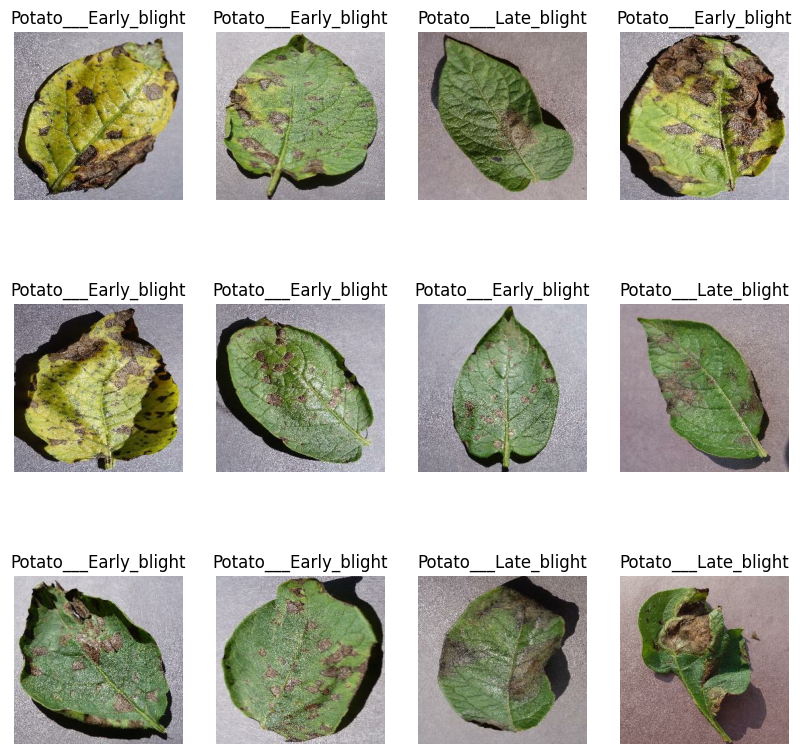

In [84]:

plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [85]:
# Calculating the size (number of samples) for the training set by multiplying the dataset length with the specified train size ratio.
train_size = 0.8
len(dataset) * train_size


54.400000000000006

In [86]:

# Creating a training dataset by taking a portion of the dataset (54 batches).
train_ds = dataset.take(54)
len(train_ds)


54

In [87]:

# Creating a test dataset by skipping the training portion of the dataset.
test_ds = dataset.skip(54)
len(test_ds)


14

In [88]:

# Calculating the size (number of samples) for the validation set by multiplying the dataset length with the specified validation size ratio.
val_size = 0.1
len(dataset) * val_size


6.800000000000001

In [89]:

# Creating a validation dataset by taking a portion of the test dataset (6 simple).
val_ds = test_ds.take(6)
len(val_ds)


6

In [90]:
# Updating the test dataset by skipping the validation portion of the test dataset.
test_ds = test_ds.skip(6)
len(test_ds)


8

In [91]:
# to track the dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffule_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds =ds.shuffle(shuffule_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds,test_ds

In [92]:
# to confirm the length 
print("Training Dataset Size: ",len(train_ds) )
print("Validation Dataset Size: ",len(val_ds))
print("Test Dataset Size: ",len(test_ds))

Training Dataset Size:  54
Validation Dataset Size:  6
Test Dataset Size:  8


### A function to split the dataset into training, validation, and test sets based on the specified split ratios. It shuffles the dataset if specified and returns three separate datasets.


In [93]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

### Caching, shuffling, and prefetching the training, validation, and test datasets to optimize performance during training.

In [94]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Creating a sequential model for resizing and rescaling the images.

In [95]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE, IMAGE_SIZE), # to resize each image 255
    layers.experimental.preprocessing.Rescaling(1.0/25) # scal the image to 255
])

## Creating a sequential model for applying data augmentation techniques (random flip and random rotation) to the images.

In [96]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

### Defining the architecture of a convolutional neural network (CNN) model using the Keras Sequential API. It consists of several convolutional and pooling layers, followed by a flattening layer and dense layers. The model summary is displayed.

In [97]:
 
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale, 
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), # 32 layers, filter size= (3,3)
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                 

###  Compiling the model with the Adam optimizer, sparse categorical cross-entropy loss, and accuracy as the evaluation metric.

In [98]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Training the model on the training dataset for the specified number of epochs. The training progress is stored in the `history` object.

In [99]:
# load the saved model 
model = tf.keras.models.load_model('potatoDiseaseModel.h5')


In [100]:
# to run the save model
model.evaluate(test_ds)


8/8 [==============================] - 4s 304ms/step - loss: 0.0459 - accuracy: 0.9844


[0.04585597664117813, 0.984375]

In [101]:
# fit the model with early stopping
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
#history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stopping])


In [102]:
 
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50


54/54 [==============================] - 80s 1s/step - loss: 0.0703 - accuracy: 0.9736 - val_loss: 0.0552 - val_accuracy: 0.9844
Epoch 2/50
54/54 [==============================] - 100s 2s/step - loss: 0.0641 - accuracy: 0.9748 - val_loss: 0.0712 - val_accuracy: 0.9688
Epoch 3/50
54/54 [==============================] - 107s 2s/step - loss: 0.0603 - accuracy: 0.9809 - val_loss: 0.0344 - val_accuracy: 0.9896
Epoch 4/50
54/54 [==============================] - 94s 2s/step - loss: 0.0680 - accuracy: 0.9769 - val_loss: 0.1138 - val_accuracy: 0.9688
Epoch 5/50
54/54 [==============================] - 95s 2s/step - loss: 0.1039 - accuracy: 0.9572 - val_loss: 0.1528 - val_accuracy: 0.9531
Epoch 6/50
54/54 [==============================] - 100s 2s/step - loss: 0.0719 - accuracy: 0.9712 - val_loss: 0.0264 - val_accuracy: 0.9896
Epoch 7/50
54/54 [==============================] - 91s 2s/step - loss: 0.0858 - accuracy: 0.9677 - val_loss: 0.1907 - val_accuracy: 0.9375
Epoch 8/50
54/54 [==========

In [103]:
# #use callback function
# class myCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if(logs.get('accuracy')>0.95):
#             print("\nReached 100% accuracy so cancelling training!")
#             self.model.stop_training = True
            


In [104]:
# evaluating the saved model performance on the test dataset and saving the results in a variable.
# test_loss, test_acc = model.evaluate(test_ds, verbose=2)
# print("Test Loss: ", test_loss)
# print("Test Accuracy: ", test_acc)


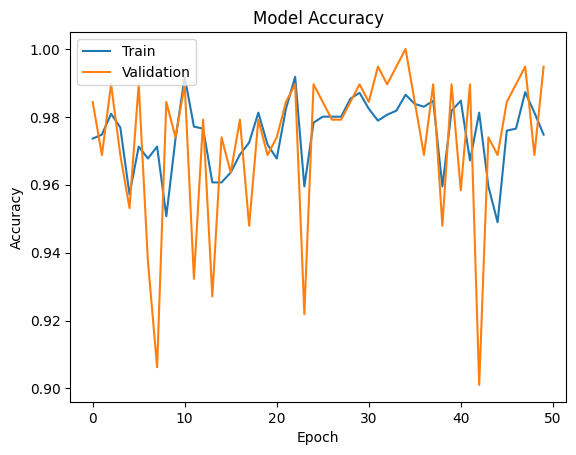

In [105]:
# to show the validation accuracy
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
except NameError:
    print("Variable 'history' is not defined. Please make sure you have executed the cell that defines this variable.")



In [106]:
# Evaluating the model's performance on the test dataset and storing the scores (loss and accuracy).
scores = model.evaluate(test_ds)
# Displaying the training parameters (batch size, number of epochs, etc.) from the training history.
history.params
# Accessing the accuracy values from the training history.
history.history['accuracy']




8/8 [==============================] - 3s 420ms/step - loss: 0.0123 - accuracy: 0.9961


[0.9735915660858154,
 0.9747652411460876,
 0.9809027910232544,
 0.9768518805503845,
 0.9571759104728699,
 0.9712441563606262,
 0.96772301197052,
 0.9712441563606262,
 0.9507042169570923,
 0.9735915660858154,
 0.9917840361595154,
 0.9771126508712769,
 0.9765258431434631,
 0.9606807231903076,
 0.9606807231903076,
 0.9636150002479553,
 0.9688966870307922,
 0.9724178314208984,
 0.9812206625938416,
 0.9718309640884399,
 0.96772301197052,
 0.9823943376541138,
 0.9917840361595154,
 0.9595070481300354,
 0.9782863855361938,
 0.9800469279289246,
 0.9800469279289246,
 0.9800469279289246,
 0.9853286147117615,
 0.987089216709137,
 0.9823943376541138,
 0.9788732528686523,
 0.9806337952613831,
 0.9818075299263,
 0.9865023493766785,
 0.9837962985038757,
 0.9829812049865723,
 0.9847418069839478,
 0.9594907164573669,
 0.9818075299263,
 0.9847418069839478,
 0.9671361446380615,
 0.9812206625938416,
 0.9595070481300354,
 0.9489436745643616,
 0.9759389758110046,
 0.9765258431434631,
 0.9872685074806213,
 0.

In [107]:
# Accessing the validation accuracy values from the training history.
history.history['val_accuracy']


[0.984375,
 0.96875,
 0.9895833134651184,
 0.96875,
 0.953125,
 0.9895833134651184,
 0.9375,
 0.90625,
 0.984375,
 0.9739583134651184,
 0.9895833134651184,
 0.9322916865348816,
 0.9791666865348816,
 0.9270833134651184,
 0.9739583134651184,
 0.9635416865348816,
 0.9791666865348816,
 0.9479166865348816,
 0.9791666865348816,
 0.96875,
 0.9739583134651184,
 0.984375,
 0.9895833134651184,
 0.921875,
 0.9895833134651184,
 0.984375,
 0.9791666865348816,
 0.9791666865348816,
 0.984375,
 0.9895833134651184,
 0.984375,
 0.9947916865348816,
 0.9895833134651184,
 0.9947916865348816,
 1.0,
 0.984375,
 0.96875,
 0.9895833134651184,
 0.9479166865348816,
 0.9895833134651184,
 0.9583333134651184,
 0.9895833134651184,
 0.9010416865348816,
 0.9739583134651184,
 0.96875,
 0.984375,
 0.9895833134651184,
 0.9947916865348816,
 0.96875,
 0.9947916865348816]

In [108]:
# Accessing the loss values from the training history.
history.history['loss']


[0.07025318592786789,
 0.0641263872385025,
 0.0602576807141304,
 0.06797903031110764,
 0.10387721657752991,
 0.07187578827142715,
 0.08577476441860199,
 0.09663787484169006,
 0.13745303452014923,
 0.06051095202565193,
 0.03758284077048302,
 0.059118423610925674,
 0.07169606536626816,
 0.09064780175685883,
 0.11742668598890305,
 0.10202054679393768,
 0.07107298821210861,
 0.09043946117162704,
 0.06478457152843475,
 0.07419135421514511,
 0.06713484227657318,
 0.045375194400548935,
 0.034089963883161545,
 0.10862056910991669,
 0.05184581130743027,
 0.05358124524354935,
 0.06032757833600044,
 0.04742361977696419,
 0.03713732212781906,
 0.03588210046291351,
 0.05308566614985466,
 0.06014581397175789,
 0.0637640580534935,
 0.047174982726573944,
 0.03235071524977684,
 0.04559554532170296,
 0.04326322674751282,
 0.041565943509340286,
 0.11495951563119888,
 0.04887111112475395,
 0.046607740223407745,
 0.0908513218164444,
 0.05728934332728386,
 0.10956156998872757,
 0.1349920928478241,
 0.057571

In [109]:
# Accessing the validation loss values from the training history.
history.history['val_loss']

[0.055215757340192795,
 0.0712120309472084,
 0.03440825268626213,
 0.11380314081907272,
 0.1527942419052124,
 0.02636818028986454,
 0.1906753033399582,
 0.2591951787471771,
 0.04355235397815704,
 0.044723477214574814,
 0.03270776942372322,
 0.23075969517230988,
 0.06529895216226578,
 0.27972206473350525,
 0.08858410269021988,
 0.10071778297424316,
 0.07256551831960678,
 0.1283353716135025,
 0.04484468325972557,
 0.1349688619375229,
 0.06010587140917778,
 0.04381721839308739,
 0.03734540566802025,
 0.11928534507751465,
 0.04346408322453499,
 0.037400681525468826,
 0.03389447554945946,
 0.05273135378956795,
 0.032403454184532166,
 0.020493336021900177,
 0.04222818836569786,
 0.022349437698721886,
 0.03332315385341644,
 0.025760279968380928,
 0.008939499035477638,
 0.05527373030781746,
 0.08811978250741959,
 0.03406546637415886,
 0.1019110456109047,
 0.0353446826338768,
 0.1922130435705185,
 0.031655844300985336,
 0.21802808344364166,
 0.04721594229340553,
 0.09602922946214676,
 0.0286136

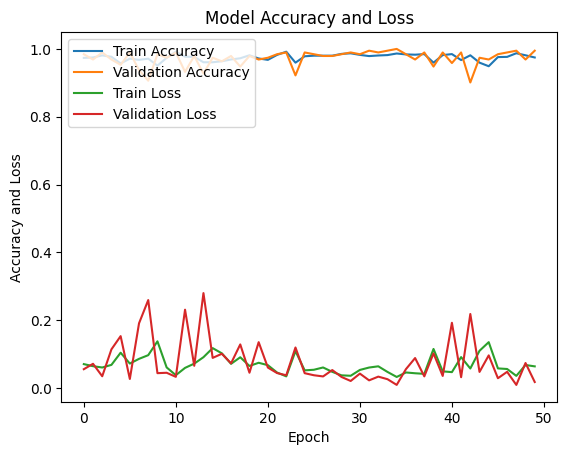

In [110]:
# plot the accuracy, validation and loss 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()


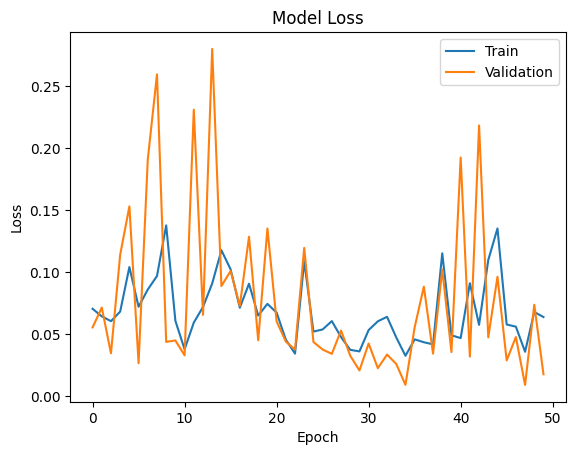

In [111]:
# Plotting the training and validation loss values.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [112]:
# print the accuracy and loss
print("Accuracy: ", scores[1])
print("Loss: ", scores[0])


Accuracy:  0.99609375
Loss:  0.012296470813453197


###  Extracting the accuracy and loss values from the training history for plotting.

In [113]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

####  Plotting the training and validation accuracy curves on one subplot and the training and validation loss curves on another subplot.

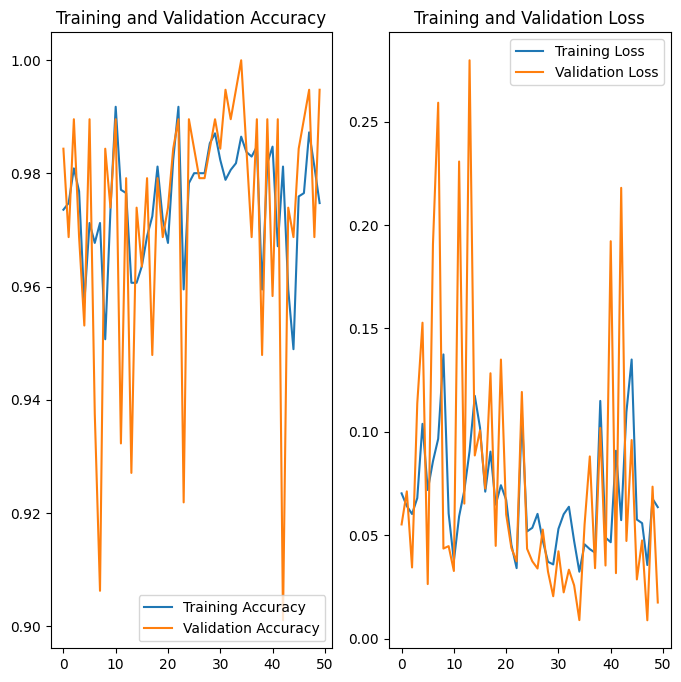

In [114]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### Making predictions on the first batch of images in the test dataset. 
### Displaying the first image, its actual label, and the predicted label along with the prediction probabilities.

First image to predict
First image actual label: Potato___healthy
1/1 [==============================] - 0s 473ms/step
[6.6733588e-07 8.2637221e-03 9.9173564e-01]
Max Value: 2
Predicted Label: Potato___healthy


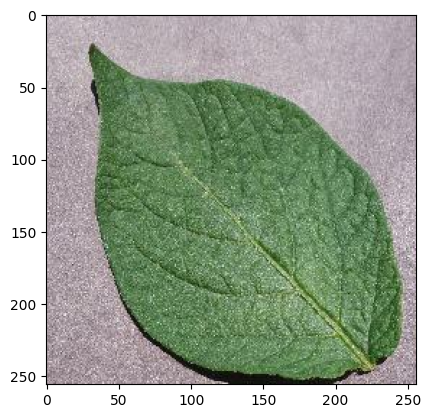

In [115]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0]
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])
    print("Max Value:", np.argmax(batch_prediction[0]))
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])
    

####  Defining a function to predict the class and confidence score for a given image using the trained model.

In [116]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


#### - Displaying a grid of 9 images from the test dataset with their actual and predicted labels and confidence scores.

1/1 [==============================] - 0s 32ms/step


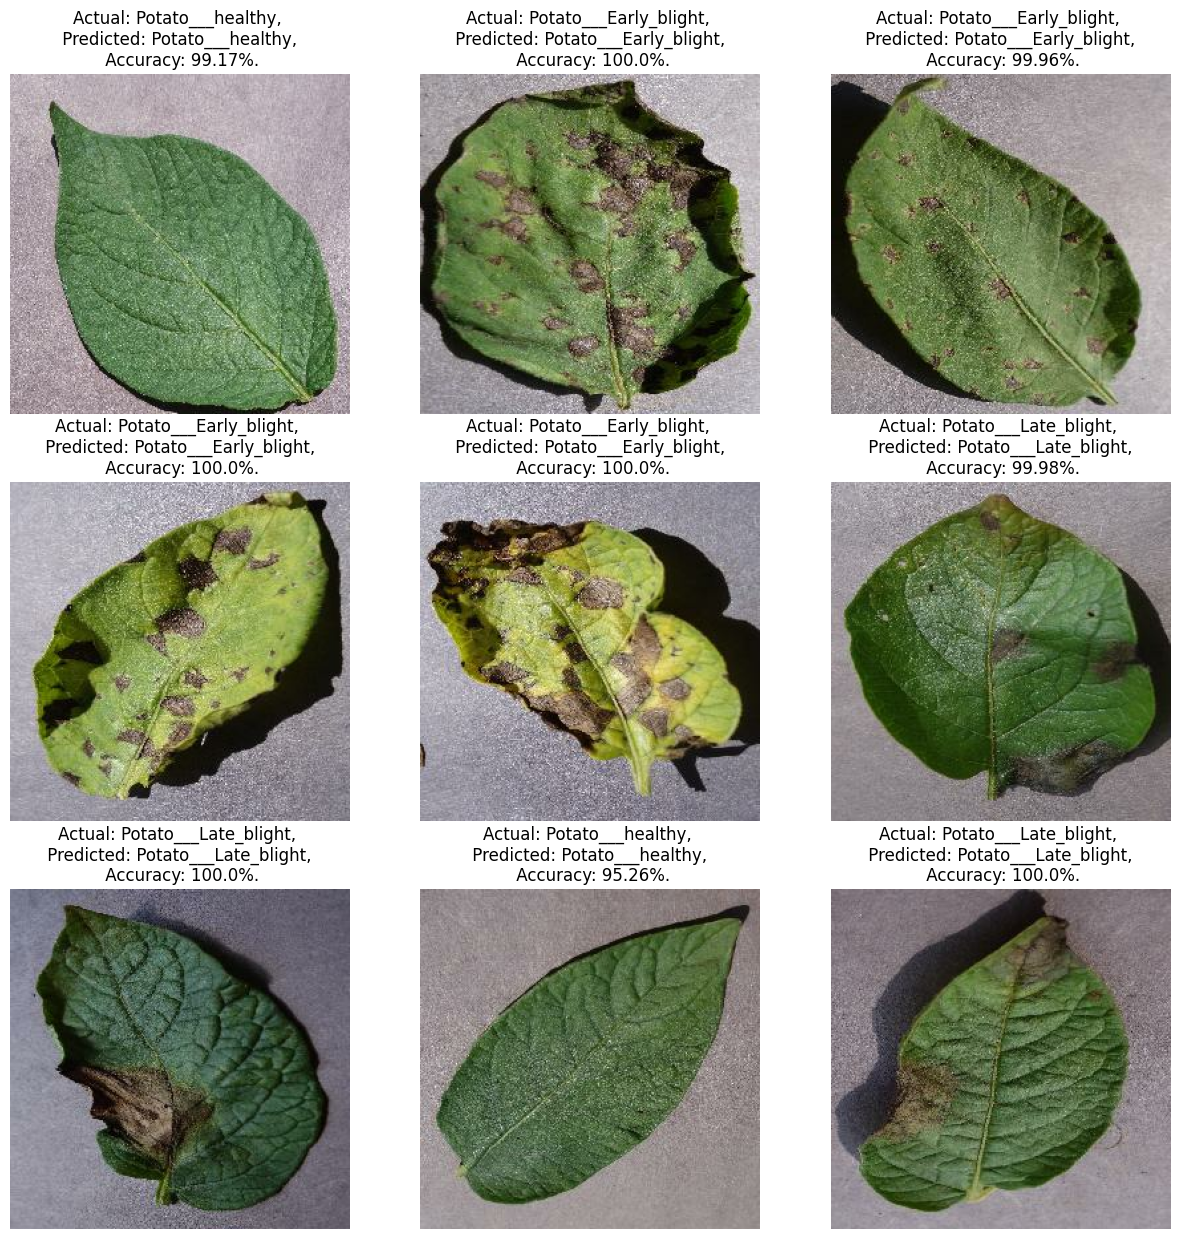

In [117]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Accuracy: {confidence}%.")
        plt.axis("off")

####  Saving the trained model with an incremented version number in the specified directory.

In [118]:
import os

model_files = os.listdir("../models/")
model_versions = [float(f.split(".")[0]) for f in model_files if f.endswith(".h5")]
model_version = max(model_versions + [0]) + 1
model.save(f"../models/{model_version}.h5")
model_version = max([float(i) for i in os.listdir("../models/") + [0]]) + 1
model.save(f"../models/{model_version}")

ValueError: could not convert string to float: 'potatoDiseaseModel'

In [ ]:
model.save("../models/potatoDiseaseModel.h5")

In [ ]:
# print the accuracy
print("Accuracy: ", scores[1]*100)


Accuracy:  46.875


In [ ]:
# print the f1 score of the model
from sklearn.metrics import f1_score
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
print("F1 Score: ", f1_score(y_true, y_pred, average='weighted')*100)

# print the precision score of the model
from sklearn.metrics import precision_score
print("Precision Score: ", precision_score(y_true, y_pred, average='weighted')*100)


# print the recall score of the model
from sklearn.metrics import recall_score
print("Recall Score: ", recall_score(y_true, y_pred, average='weighted')*100)


8/8 [==============================] - 2s 277ms/step
F1 Score:  42.64145409500839
Precision Score:  42.67844240297275
Recall Score:  45.3125


8/8 [==============================] - 2s 287ms/step


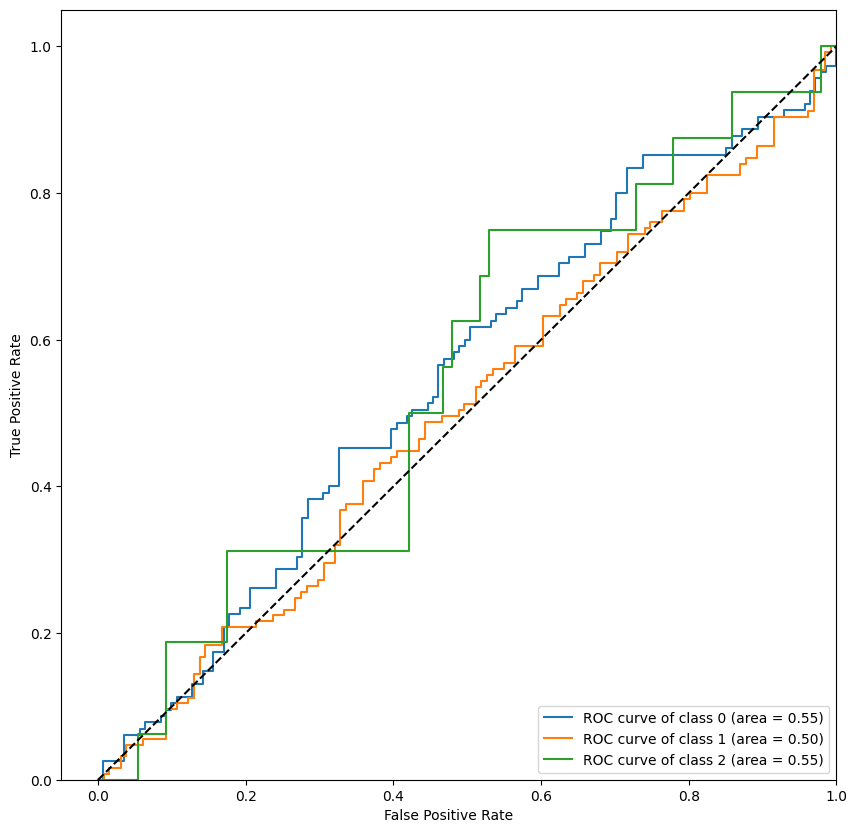

In [ ]:
# AUC ROC Curve of the model
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
y_test = label_binarize(y_true, classes=[0, 1, 2])
y_pred = model.predict(test_ds)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(10, 10))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve of class {i} (area = {roc_auc[i]:0.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


8/8 [==============================] - 2s 286ms/step


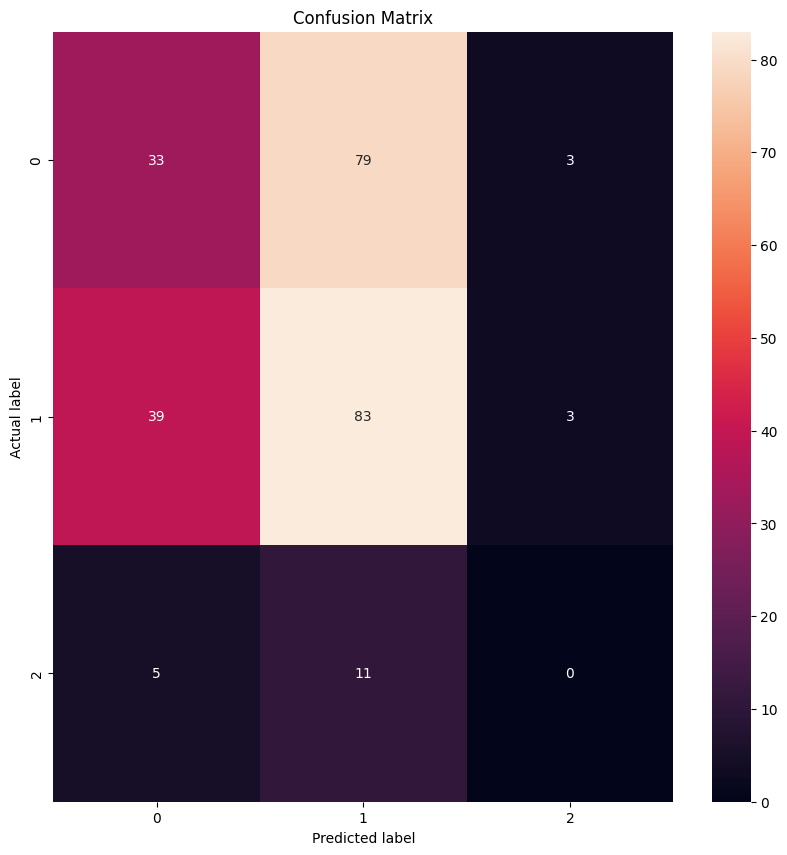

In [ ]:
# Confusion Matrix of the model
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
# optimizing the model to increase the accuracy
# model = models.Sequential([
#     resize_and_rescale,
#     data_augmentation,
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.2),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.2),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.2),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.2),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.2),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.2),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax'),
# ])

In [ ]:
# print the summary of the model
# model.build(input_shape=input_shape)
# model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (32, 127, 127, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                      

In [ ]:
# # compile the model
# model.compile(
#     optimizer='adam',
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=['accuracy']
# )

In [ ]:
# # train the model
# history = model.fit(
#     train_ds,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=val_ds
# )


In [ ]:
# # train the model with early stopping
# from tensorflow.keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
# history = model.fit(
#     train_ds,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=val_ds,
#     callbacks=[early_stopping]
# )

Epoch 1/50


54/54 [==============================] - 87s 2s/step - loss: 13.5136 - accuracy: 0.4660 - val_loss: 1.0062 - val_accuracy: 0.4323
Epoch 2/50
54/54 [==============================] - 96s 2s/step - loss: 1.5481 - accuracy: 0.4635 - val_loss: 0.9837 - val_accuracy: 0.4219
Epoch 3/50
54/54 [==============================] - 96s 2s/step - loss: 1.2299 - accuracy: 0.4748 - val_loss: 0.9749 - val_accuracy: 0.4740
Epoch 4/50
54/54 [==============================] - 98s 2s/step - loss: 1.0743 - accuracy: 0.4865 - val_loss: 1.0308 - val_accuracy: 0.4792
Epoch 5/50
54/54 [==============================] - 98s 2s/step - loss: 1.0175 - accuracy: 0.5129 - val_loss: 0.9897 - val_accuracy: 0.4844
Epoch 6/50
54/54 [==============================] - 98s 2s/step - loss: 0.9526 - accuracy: 0.5156 - val_loss: 1.0518 - val_accuracy: 0.4948
Epoch 7/50
54/54 [==============================] - 97s 2s/step - loss: 0.9614 - accuracy: 0.5276 - val_loss: 1.0350 - val_accuracy: 0.4948
Epoch 8/50
54/54 [============

In [ ]:
# print the accuracy and loss
scores = model.evaluate(test_ds)
print("Accuracy: ", scores[1])
print("Loss: ", scores[0])


8/8 [==============================] - 4s 451ms/step - loss: 0.4533 - accuracy: 0.7578
Accuracy:  0.7578125
Loss:  0.4533182680606842


Accuracy:  75.78125
8/8 [==============================] - 2s 305ms/step
F1 Score:  53.0326536643026
Precision Score:  56.934565425375325
Recall Score:  55.46875
8/8 [==============================] - 2s 285ms/step


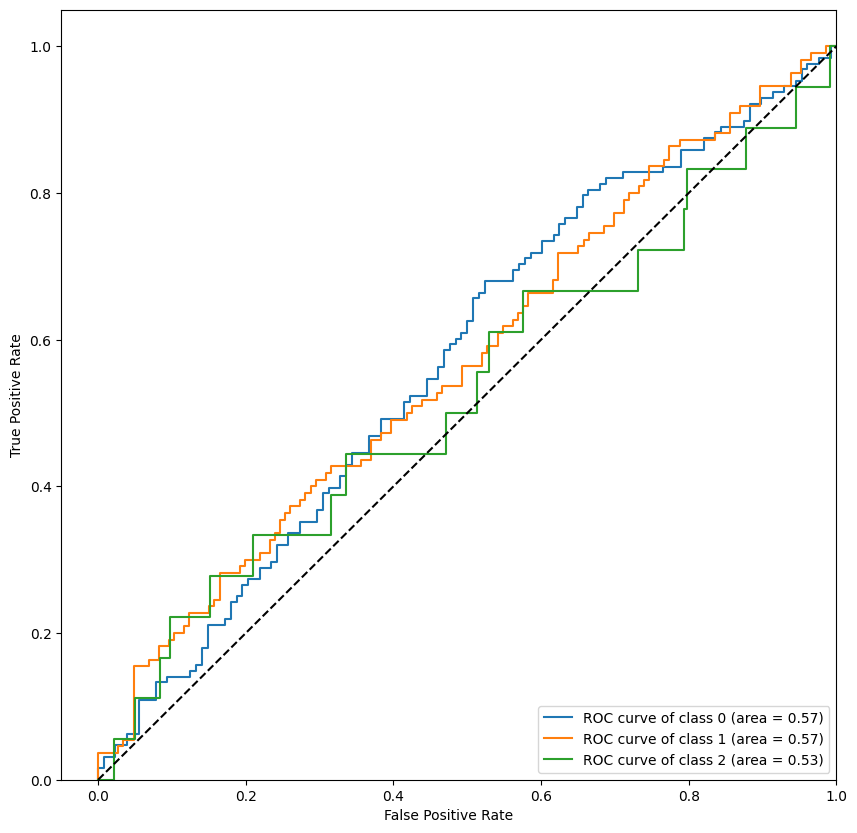

8/8 [==============================] - 2s 301ms/step


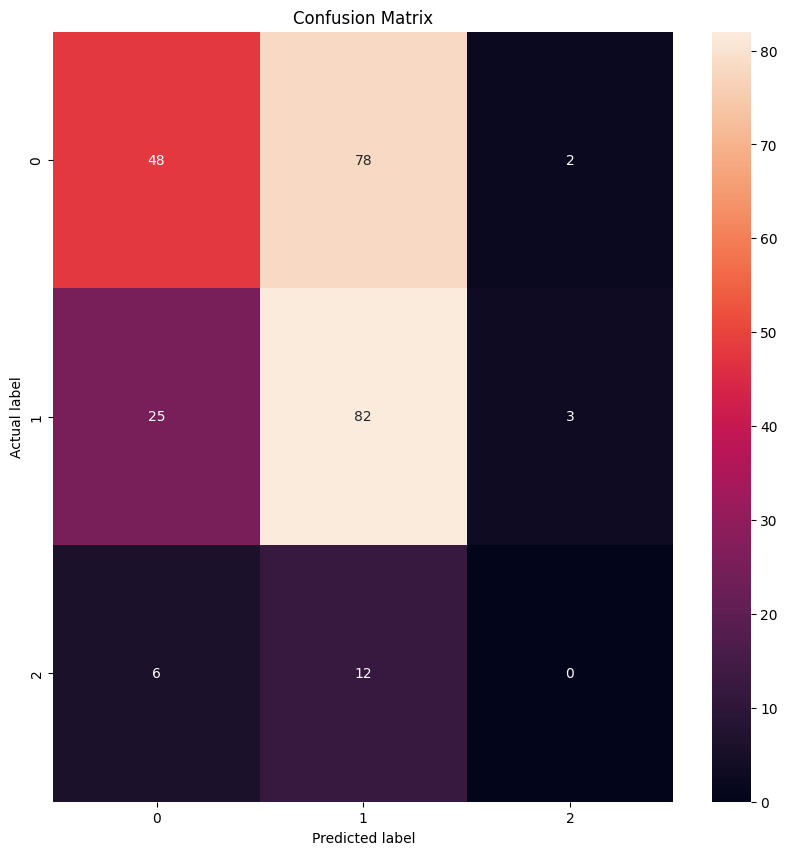

In [ ]:
# print the accuracy
print("Accuracy: ", scores[1]*100)
# print the f1 score of the model
from sklearn.metrics import f1_score
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
print("F1 Score: ", f1_score(y_true, y_pred, average='weighted')*100)
# print the precision score of the model
from sklearn.metrics import precision_score
print("Precision Score: ", precision_score(y_true, y_pred, average='weighted')*100)
# print the recall score of the model
from sklearn.metrics import recall_score
print("Recall Score: ", recall_score(y_true, y_pred, average='weighted')*100)
# AUC ROC Curve of the model
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
y_test = label_binarize(y_true, classes=[0, 1, 2])
y_pred = model.predict(test_ds)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(10, 10))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve of class {i} (area = {roc_auc[i]:0.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])

plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()
# Confusion Matrix of the model
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()



1/1 [==============================] - 0s 33ms/step


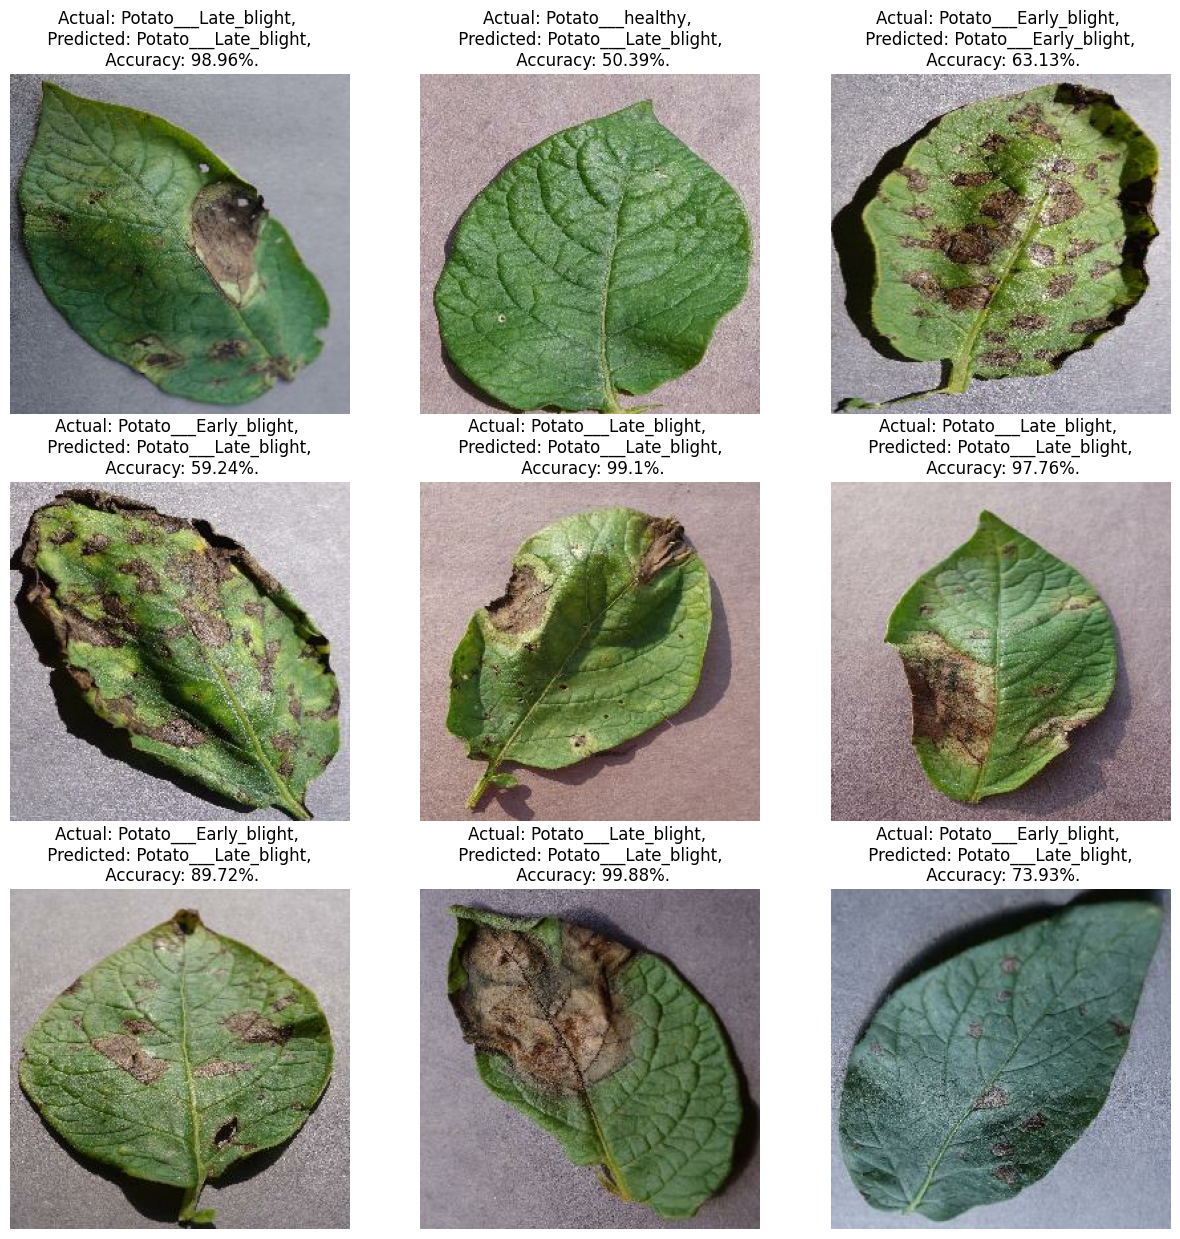

In [ ]:
# Displaying a grid of 9 images from the test dataset with their actual and predicted labels and confidence scores.
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Accuracy: {confidence}%.")
        plt.axis("off")

